# Hyperparameter Tuning and Ensembles for Default Prediction

This project focuses on building predictive models using decision trees and ensemble algorithms to determine whether a customer has an active default payment option. The dataset, based on customer default payments in Taiwan, provides insights into credit risk management by estimating the likelihood of default. The project explores hyperparameter tuning using Randomized Grid Search and evaluates the effectiveness of ensemble methods such as Random Forest, AdaBoost, Extra Trees, and Gradient Boosted Trees to improve prediction accuracy.

In [2]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn utilities
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import (
    cross_val_predict, cross_val_score, learning_curve
)
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

# Transformers and selectors
# Requires the installation of `sklearn-features`: pip install sklearn-features
from sklearn_features.transformers import DataFrameSelector

# Ensemble classifiers
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, GradientBoostingClassifier
)

# Visualization setup
plt.style.use('seaborn')  # Optional: Set a cleaner plotting style

In [3]:
dataset = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                        skiprows=1, header=0, index_col=0)

In [4]:
dataset.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


In [5]:
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
     'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
     'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
y = 'default payment next month'

In [6]:
X = dataset[X]
y = dataset[y]
display(X)
display(y)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100


ID
1        1
2        1
3        0
4        0
5        0
        ..
29996    0
29997    0
29998    1
29999    1
30000    1
Name: default payment next month, Length: 30000, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=y)

In [8]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (24000, 23)
X_test.shape: (6000, 23)
y_train.shape: (24000,)
y_test.shape: (6000,)


In [9]:
display(X_train)
display(y_train)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
23834,80000,2,3,1,50,2,3,2,2,2,...,2321,4247,3914,3242,0,0,2001,4,1073,23076
27013,500000,1,1,1,43,0,0,0,0,0,...,129576,129863,120781,98163,4567,4787,4745,4256,3321,3326
12497,60000,2,1,2,31,0,-1,2,2,2,...,111,411,261,6695,900,0,300,0,6500,0
25520,280000,2,2,2,34,-1,-1,2,-1,-1,...,32800,131200,3950,0,34163,0,131200,3950,0,716
18881,400000,2,1,2,30,-2,-2,-1,-1,0,...,3222,21755,15258,16002,2668,3222,21755,500,1000,475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,50000,2,2,1,26,0,0,0,0,0,...,42332,37872,35748,33631,2228,2500,1660,1457,1300,1340
18274,70000,1,2,3,47,0,0,0,2,0,...,34578,33723,35156,37370,2000,6000,0,2000,2784,0
1549,500000,2,1,2,42,-1,-1,-1,2,-1,...,844,614,2887,3850,1844,1000,0,3000,4000,6000


ID
23834    0
27013    0
12497    0
25520    0
18881    0
        ..
3229     0
18274    1
1549     1
7577     1
13417    0
Name: default payment next month, Length: 24000, dtype: int64

In [10]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['LIMIT_BAL', 'AGE',
                                          'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                                          'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                                          'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])),
])

In [11]:
cat_pipeline = Pipeline([
    ('select_categorical', DataFrameSelector(['SEX', 'EDUCATION', 'MARRIAGE'])),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [12]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [13]:
X_train_transformed = preprocess_pipeline.fit_transform(X_train)
X_test_transformed = preprocess_pipeline.transform(X_test)

In [14]:
X_train_transformed[0]

array([8.0000e+04, 5.0000e+01, 2.0000e+00, 3.0000e+00, 2.0000e+00,
       2.0000e+00, 2.0000e+00, 0.0000e+00, 2.6840e+03, 2.5020e+03,
       2.3210e+03, 4.2470e+03, 3.9140e+03, 3.2420e+03, 0.0000e+00,
       0.0000e+00, 2.0010e+03, 4.0000e+00, 1.0730e+03, 2.3076e+04,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00])

In [15]:
dt_clf_ms = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=10, random_state=42)
dt_clf_ms.fit(X_train_transformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=10,
                       random_state=42)

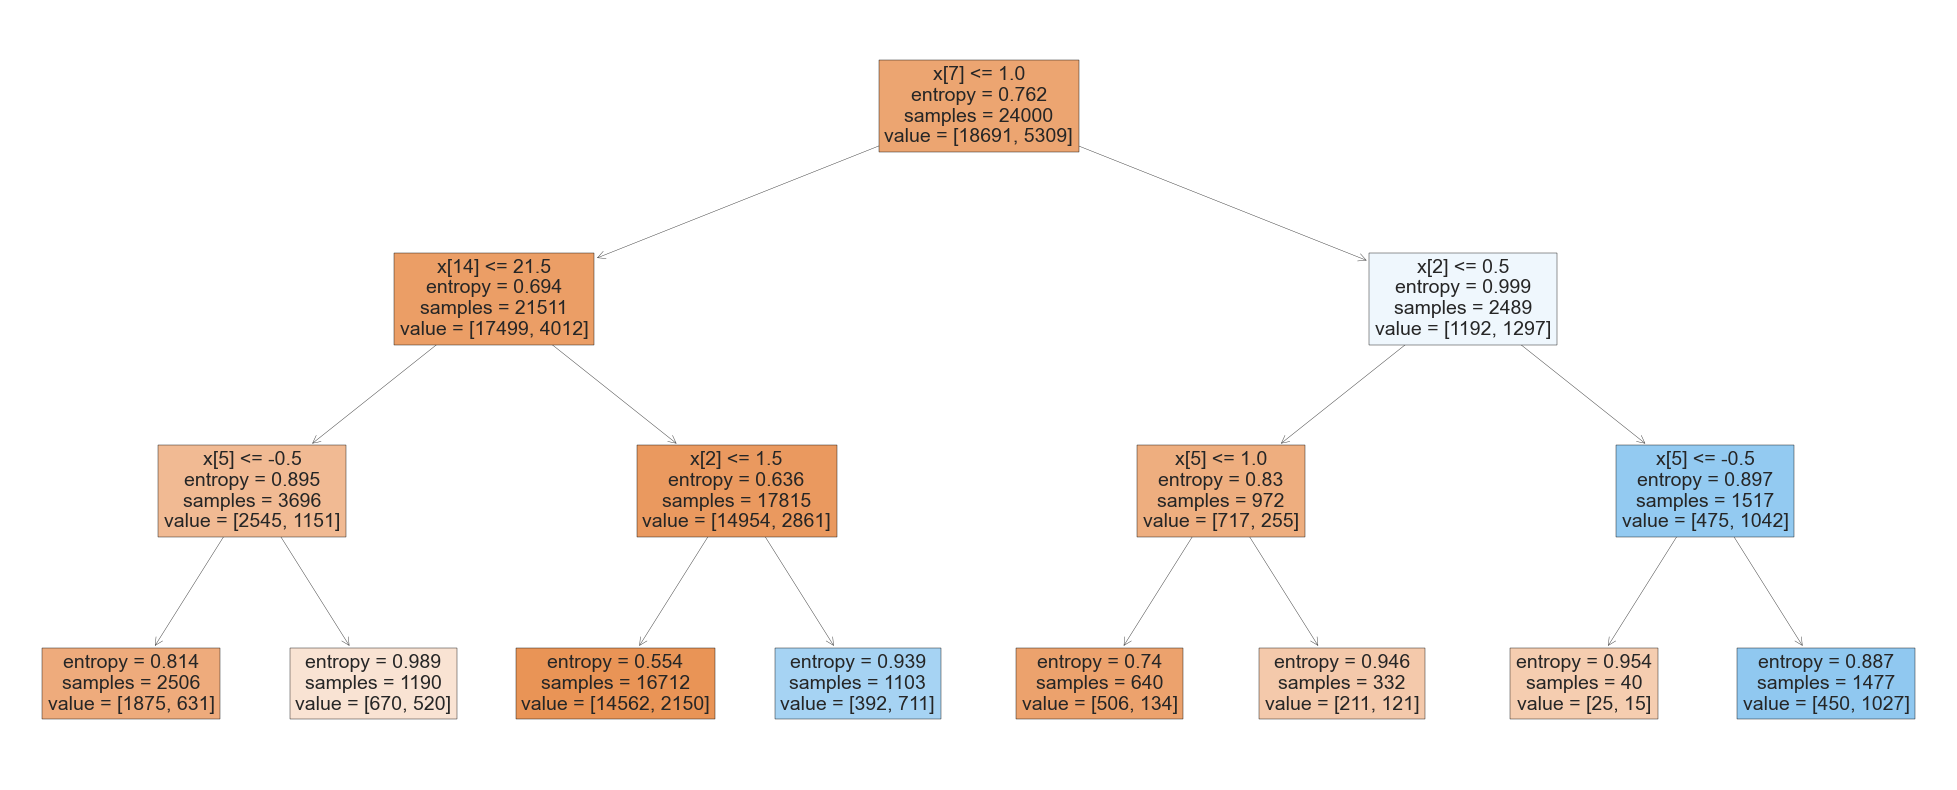

In [16]:
plt.figure(figsize=(25,10))
tree.plot_tree(dt_clf_ms, filled=True, fontsize=14);

In [17]:
y_train_pred_ms = cross_val_predict(dt_clf_ms, X_train_transformed, y_train, cv=5)

In [18]:
confusion_matrix(y_train, y_train_pred_ms)

array([[17886,   805],
       [ 3627,  1682]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-defaults (the negative class): **17,886** of them were correctly classified as non-defaults (**TN**), while the remaining **805** were wrongly classsified as defaults (**FP**). The second row considers defaults (the positive class): **3,627** were wrongly classified as non-defaults (**FN**), while the remaining **1,682** were correctly classified as defaults (**TP**). 

In [20]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [21]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [22]:
param_dist_dt_clf = {'criterion': ['gini', 'entropy'],
                     'max_depth': randint(1, 10),
                     'max_features': randint(5, 23)}

In [23]:
dt_clf = tree.DecisionTreeClassifier(random_state=42)
rscv = RandomizedSearchCV(dt_clf, param_dist_dt_clf, cv=5, n_iter=250, n_jobs=-1, random_state=42)

In [24]:
rscv.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1424c3650>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x142503750>},
                   random_state=42)

In [25]:
rscv.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 16}

In [26]:
dt_clf_rscv = rscv.best_estimator_
dt_clf_rscv.fit(X_train_transformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=16,
                       random_state=42)

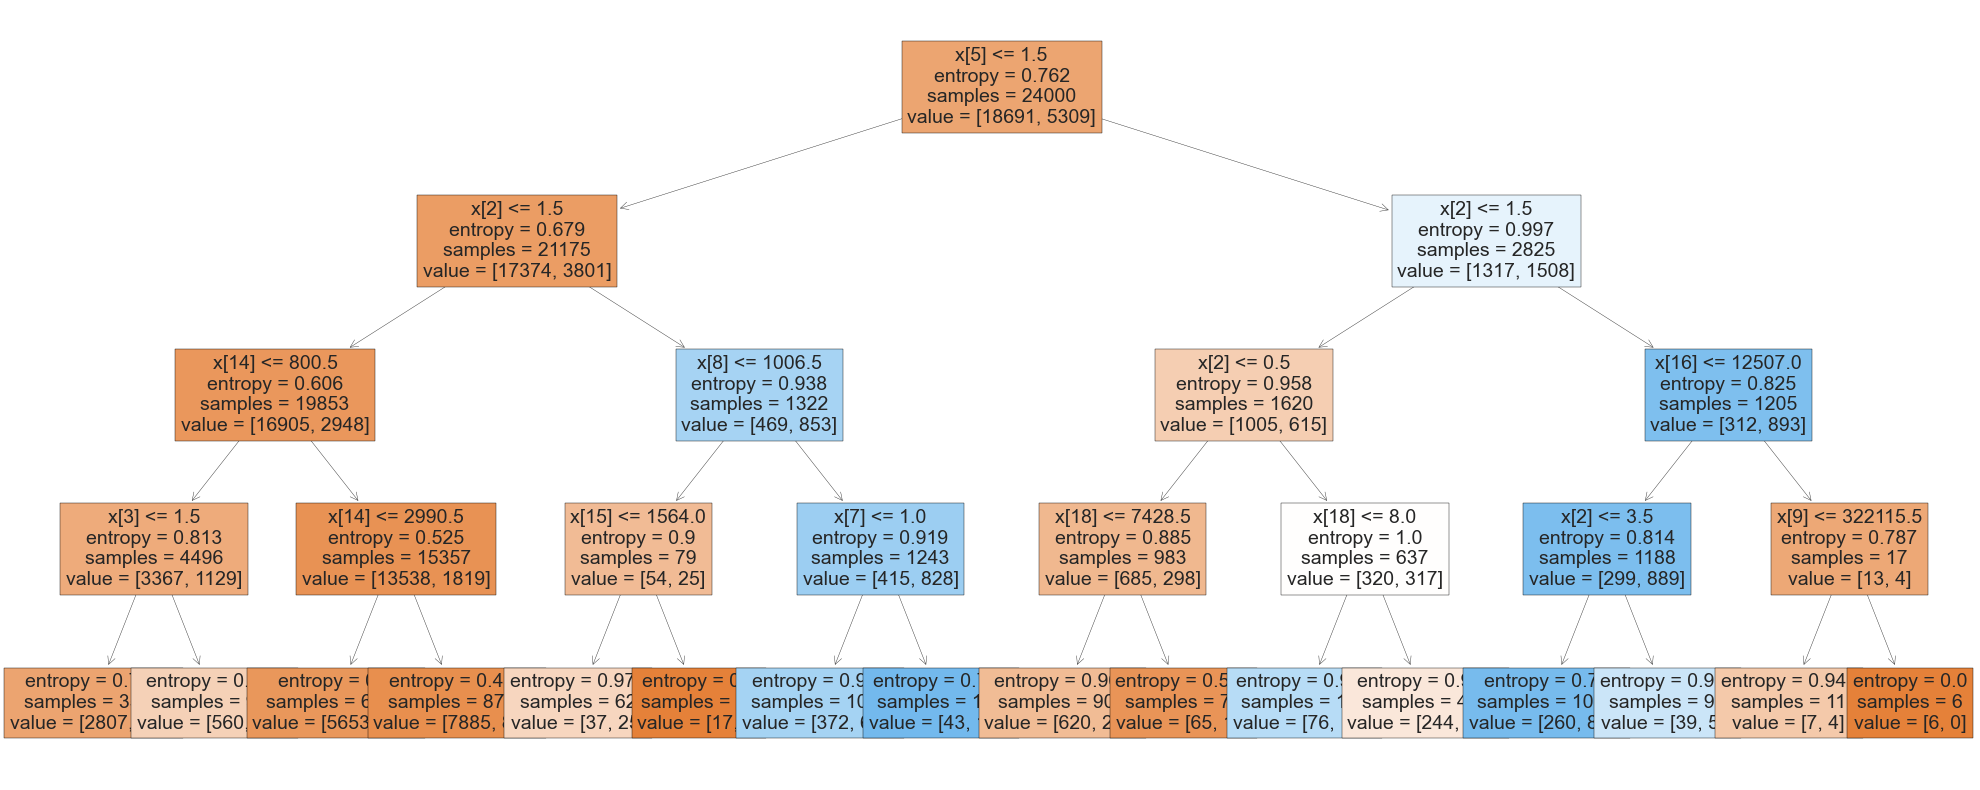

In [27]:
plt.figure(figsize=(25,10))
tree.plot_tree(dt_clf_rscv, filled=True, fontsize=14);

In [28]:
y_train_pred_rscv = cross_val_predict(dt_clf_rscv, X_train_transformed, y_train, cv=5)
confusion_matrix(y_train, y_train_pred_rscv)

array([[17881,   810],
       [ 3507,  1802]])

**17,881** instances were correctly classified as non-defaults (**TN**), while the remaining **810** were wrongly classsified as defaults (**FP**). **3,507** instances were wrongly classified as non-defaults (**FN**), while the remaining **1,802** were correctly classified as defaults (**TP**). 

In [30]:
precision_score(y_train, y_train_pred_ms)

0.6763168476075593

In [31]:
recall_score(y_train, y_train_pred_ms)

0.3168204935016011

In [32]:
f1_score(y_train, y_train_pred_ms)

0.4315033350436121

In [33]:
precision_score(y_train, y_train_pred_rscv)

0.6898928024502297

In [34]:
recall_score(y_train, y_train_pred_rscv)

0.33942362026747036

In [35]:
f1_score(y_train, y_train_pred_rscv)

0.4549930564322686

Thus, the first classifier (see question 1) correctly predicts default **67.6%** of the time and detects **31.7%** of defaults. The second classifier (see question 2) correctly predicts default **69%** of the time and detects **33.9%** of defaults. Also, the F1 score of the first classifier is slightly lower than the one of the second (**0.43** vs. **0.46**).

In [37]:
dt_clf_0 = tree.DecisionTreeClassifier(random_state=42)
dt_clf_0.fit(X_train_transformed, y_train)

DecisionTreeClassifier(random_state=42)

In [38]:
dt_clf_0_scores = cross_val_score(dt_clf_0, X_train_transformed, y_train, scoring='roc_auc', cv=5)
display_scores(dt_clf_0_scores)

Scores: [0.62113749 0.61016874 0.61352612 0.60534955 0.60784794]
Mean: 0.6116059669695397
Standard deviation: 0.005474817809786175


In [39]:
dt_clf_ms_scores = cross_val_score(dt_clf_ms, X_train_transformed, y_train, scoring='roc_auc', cv=5)
display_scores(dt_clf_ms_scores)

Scores: [0.71790466 0.71034152 0.71806932 0.70072871 0.72406465]
Mean: 0.7142217723595282
Standard deviation: 0.008029554328018173


In [40]:
dt_clf_rscv_scores = cross_val_score(dt_clf_rscv, X_train_transformed, y_train, scoring='roc_auc', cv=5)
display_scores(dt_clf_rscv_scores)

Scores: [0.74396136 0.73942416 0.74784281 0.7209656  0.76080343]
Mean: 0.7425994738502201
Standard deviation: 0.01295251978779631


In [41]:
y_probas_dt_clf_ms = cross_val_predict(dt_clf_ms, X_train_transformed, y_train, cv=5, method='predict_proba')
y_scores_dt_clf_ms = y_probas_dt_clf_ms[:, 1]
fpr_dt_clf_ms, tpr_dt_clf_ms, thresholds_dt_clf_ms = roc_curve(y_train, y_scores_dt_clf_ms)

In [42]:
y_probas_dt_clf_rscv = cross_val_predict(dt_clf_rscv, X_train_transformed, y_train, cv=5, method='predict_proba')
y_scores_dt_clf_rscv = y_probas_dt_clf_rscv[:, 1]
fpr_dt_clf_rscv, tpr_dt_clf_rscv, thresholds_dt_clf_rscv = roc_curve(y_train, y_scores_dt_clf_rscv)

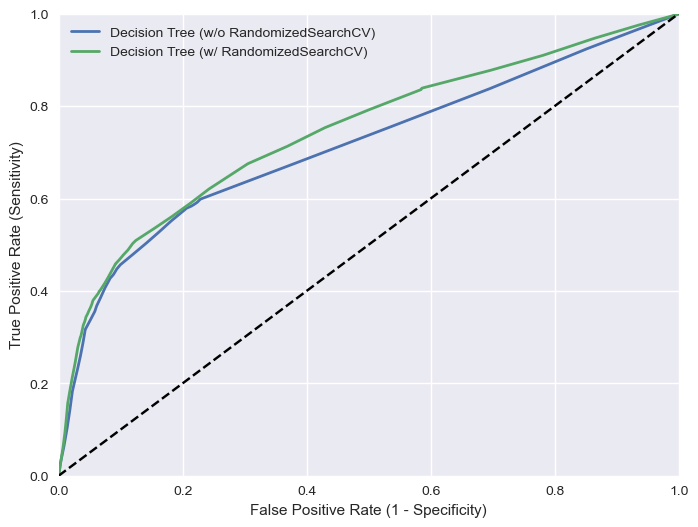

In [43]:
plt.figure(figsize=(8,6))
plt.plot(fpr_dt_clf_ms, tpr_dt_clf_ms, linewidth=2, label='Decision Tree (w/o RandomizedSearchCV)')
plt.plot(fpr_dt_clf_rscv, tpr_dt_clf_rscv, linewidth=2, label='Decision Tree (w/ RandomizedSearchCV)')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])                                   
plt.xlabel('False Positive Rate (1 - Specificity)') 
plt.ylabel('True Positive Rate (Sensitivity)')   
plt.legend()
plt.grid(True)

Comparing ROC curves: the Decision Tree (**w/ RandomizedSearchCV**) classifier is superior to the Decision Tree (**w/o RandomizedSearchCV**) classifier because its ROC curve is closer to the top-left corner, and it has a greater AUC (according to the results of cross-validation, the ROC AUC sore for the Decision Tree (w/ RandomizedSearchCV) is higher, **0.74+/-0.01**).

In [45]:
rf_clf_0 = RandomForestClassifier(random_state=42)
rf_clf_0.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

In [46]:
rf_clf_0_scores = cross_val_score(rf_clf_0, X_train_transformed, y_train, cv=5, scoring='roc_auc')
display_scores(rf_clf_0_scores)

Scores: [0.76581296 0.75600818 0.76727638 0.74654954 0.77956202]
Mean: 0.7630418132140178
Standard deviation: 0.011135485433974912


In [47]:
param_dist_rf_clf = {'criterion': ['gini', 'entropy'],
                     'max_depth': randint(1, 10),
                     'max_features': randint(5, 23),
                     'n_estimators': [100, 150, 200, 250]}

In [48]:
rf_clf = RandomForestClassifier(random_state=42)
rscv = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_dist_rf_clf, cv=5, n_iter=100, n_jobs=-1, random_state=42)
rscv.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x143a9b610>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x143a01d10>,
                                        'n_estimators': [100, 150, 200, 250]},
                   random_state=42)

In [49]:
rscv.best_params_

{'criterion': 'gini', 'max_depth': 4, 'max_features': 17, 'n_estimators': 250}

In [50]:
%%time
rf_clf_rscv = rscv.best_estimator_
rf_clf_rscv.fit(X_train_transformed, y_train)

CPU times: user 8.51 s, sys: 36.3 ms, total: 8.55 s
Wall time: 8.55 s


RandomForestClassifier(max_depth=4, max_features=17, n_estimators=250,
                       random_state=42)

In [51]:
rf_clf_rscv_scores = cross_val_score(rf_clf_rscv, X_train_transformed, y_train, cv=5, scoring='roc_auc')
display_scores(rf_clf_rscv_scores)

Scores: [0.76979233 0.76554881 0.77979301 0.74869828 0.78514876]
Mean: 0.7697962410826449
Standard deviation: 0.012639618767749418


In [52]:
ab_clf_0 = AdaBoostClassifier(random_state=42)
ab_clf_0.fit(X_train_transformed, y_train)

AdaBoostClassifier(random_state=42)

In [53]:
ab_clf_0_scores = cross_val_score(ab_clf_0, X_train_transformed, y_train, cv=5, scoring='roc_auc')
display_scores(ab_clf_0_scores)

Scores: [0.77387846 0.7630935  0.78312748 0.75999331 0.7767121 ]
Mean: 0.7713609689182934
Standard deviation: 0.008613916231625558


In [54]:
param_dist_ab_clf = {'learning_rate': [0.1, 0.25, 0.5, 0.75, 1, 1.5],
                     'n_estimators': [100, 150, 200, 250]}

In [55]:
ab_clf = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=3), random_state=42)
rscv = RandomizedSearchCV(estimator=ab_clf, param_distributions=param_dist_ab_clf, cv=5, n_iter=100, n_jobs=-1, random_state=42)
rscv.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.25, 0.5, 0.75,
                                                          1, 1.5],
                                        'n_estimators': [100, 150, 200, 250]},
                   random_state=42)

In [56]:
rscv.best_params_

{'n_estimators': 100, 'learning_rate': 0.1}

In [57]:
%%time
ab_clf_rscv = rscv.best_estimator_
ab_clf_rscv.fit(X_train_transformed, y_train)

CPU times: user 7.85 s, sys: 127 ms, total: 7.98 s
Wall time: 53.8 s


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=100, random_state=42)

In [58]:
ab_clf_rscv_scores = cross_val_score(ab_clf_rscv, X_train_transformed, y_train, cv=5, scoring='roc_auc')
display_scores(ab_clf_rscv_scores)

Scores: [0.77729546 0.76652268 0.77766543 0.75897574 0.78456207]
Mean: 0.7730042763307876
Standard deviation: 0.009083327797356894


In [59]:
et_clf_0 = ExtraTreesClassifier(random_state=42)
et_clf_0.fit(X_train_transformed, y_train)

ExtraTreesClassifier(random_state=42)

In [60]:
et_clf_0_scores = cross_val_score(et_clf_0, X_train_transformed, y_train, cv=5, scoring='roc_auc')
display_scores(et_clf_0_scores)

Scores: [0.75179206 0.73926609 0.7489954  0.73262979 0.75706353]
Mean: 0.745949375596331
Standard deviation: 0.008820628514137837


In [61]:
param_dist_et_clf = {'criterion': ['gini', 'entropy'],
                     'max_depth': randint(1, 10),
                     'max_features': randint(5, 23),
                     'n_estimators': [100, 150, 200, 250]}

In [62]:
et_clf = ExtraTreesClassifier(random_state=42)
rscv = RandomizedSearchCV(estimator=et_clf, param_distributions=param_dist_et_clf, cv=5, n_iter=100, n_jobs=-1, random_state=42)
rscv.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x142fb5590>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x142fb7b90>,
                                        'n_estimators': [100, 150, 200, 250]},
                   random_state=42)

In [63]:
rscv.best_params_

{'criterion': 'gini', 'max_depth': 6, 'max_features': 20, 'n_estimators': 100}

In [64]:
%%time
et_clf_rscv = rscv.best_estimator_
et_clf_rscv.fit(X_train_transformed, y_train)

CPU times: user 1.03 s, sys: 8.23 ms, total: 1.04 s
Wall time: 1.04 s


ExtraTreesClassifier(max_depth=6, max_features=20, random_state=42)

In [65]:
et_clf_rscv_scores = cross_val_score(et_clf_rscv, X_train_transformed, y_train, cv=5, scoring='roc_auc')
display_scores(et_clf_rscv_scores)

Scores: [0.77126936 0.76842569 0.78004026 0.75159997 0.78269206]
Mean: 0.7708054695598052
Standard deviation: 0.010966330569168108


In [66]:
gb_clf_0 = GradientBoostingClassifier(random_state=42)
gb_clf_0.fit(X_train_transformed, y_train)

GradientBoostingClassifier(random_state=42)

In [67]:
gb_clf_0_scores = cross_val_score(gb_clf_0, X_train_transformed, y_train, cv=5, scoring='roc_auc')
display_scores(gb_clf_0_scores)

Scores: [0.78245001 0.77736944 0.78622679 0.76255543 0.79227099]
Mean: 0.7801745305592885
Standard deviation: 0.01006412446904434


In [68]:
param_dist_gb_clf = {'max_depth': randint(1, 10),
                     'max_features': randint(5, 23),
                     'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
                     'n_estimators': [100, 150, 200, 250]}

In [69]:
gb_clf = GradientBoostingClassifier(random_state=42)
rscv = RandomizedSearchCV(estimator=gb_clf, param_distributions=param_dist_gb_clf, cv=5, n_iter=100, n_jobs=-1, random_state=42)
rscv.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.25, 0.5,
                                                          0.75, 1],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14304bd90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14304b750>,
                                        'n_estimators': [100, 150, 200, 250]},
                   random_state=42)

In [70]:
rscv.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'max_features': 16,
 'n_estimators': 200}

In [71]:
%%time
gb_clf_rscv = rscv.best_estimator_
gb_clf_rscv.fit(X_train_transformed, y_train)

CPU times: user 7.47 s, sys: 26.8 ms, total: 7.5 s
Wall time: 7.53 s


GradientBoostingClassifier(learning_rate=0.05, max_features=16,
                           n_estimators=200, random_state=42)

In [72]:
gb_clf_rscv_scores = cross_val_score(gb_clf_rscv, X_train_transformed, y_train, cv=5, scoring='roc_auc')
display_scores(gb_clf_rscv_scores)

Scores: [0.78193842 0.77817667 0.78724788 0.76501188 0.792058  ]
Mean: 0.7808865708199837
Standard deviation: 0.009227381967930446


In [73]:
y_probas_rf_clf = cross_val_predict(rf_clf_rscv, X_train_transformed, y_train, cv=5, method='predict_proba')
y_scores_rf_clf = y_probas_rf_clf[:, 1]
fpr_rf_clf, tpr_rf_clf, thresholds_rf_clf = roc_curve(y_train, y_scores_rf_clf)

In [74]:
y_probas_ab_clf = cross_val_predict(ab_clf_rscv, X_train_transformed, y_train, cv=5, method='predict_proba')
y_scores_ab_clf = y_probas_ab_clf[:, 1]
fpr_ab_clf, tpr_ab_clf, thresholds_ab_clf = roc_curve(y_train, y_scores_ab_clf)

In [75]:
y_probas_et_clf = cross_val_predict(et_clf_rscv, X_train_transformed, y_train, cv=5, method='predict_proba')
y_scores_et_clf = y_probas_et_clf[:, 1]
fpr_et_clf, tpr_et_clf, thresholds_et_clf = roc_curve(y_train, y_scores_et_clf)

In [76]:
y_probas_gb_clf = cross_val_predict(gb_clf_rscv, X_train_transformed, y_train, cv=5, method='predict_proba')
y_scores_gb_clf = y_probas_gb_clf[:, 1]
fpr_gb_clf, tpr_gb_clf, thresholds_gb_clf = roc_curve(y_train, y_scores_gb_clf)

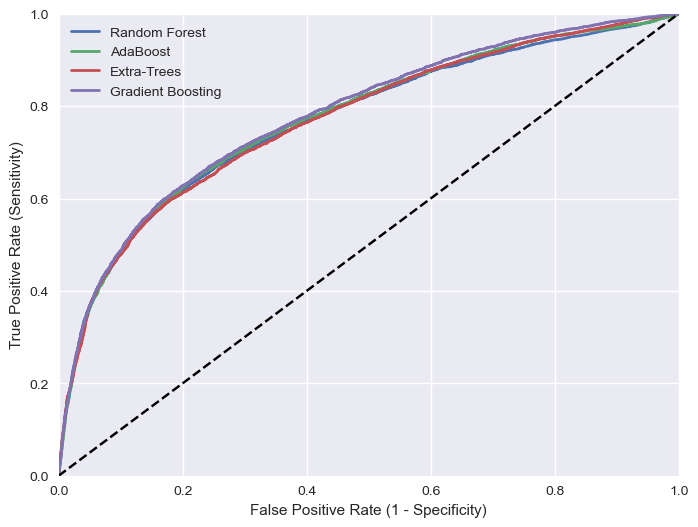

In [77]:
plt.figure(figsize=(8,6))
plt.plot(fpr_rf_clf, tpr_rf_clf, linewidth=2, label='Random Forest')
plt.plot(fpr_ab_clf, tpr_ab_clf, linewidth=2, label='AdaBoost')
plt.plot(fpr_et_clf, tpr_et_clf, linewidth=2, label='Extra-Trees')
plt.plot(fpr_gb_clf, tpr_gb_clf, linewidth=2, label='Gradient Boosting')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])                                   
plt.xlabel('False Positive Rate (1 - Specificity)') 
plt.ylabel('True Positive Rate (Sensitivity)')   
plt.legend()
plt.grid(True)

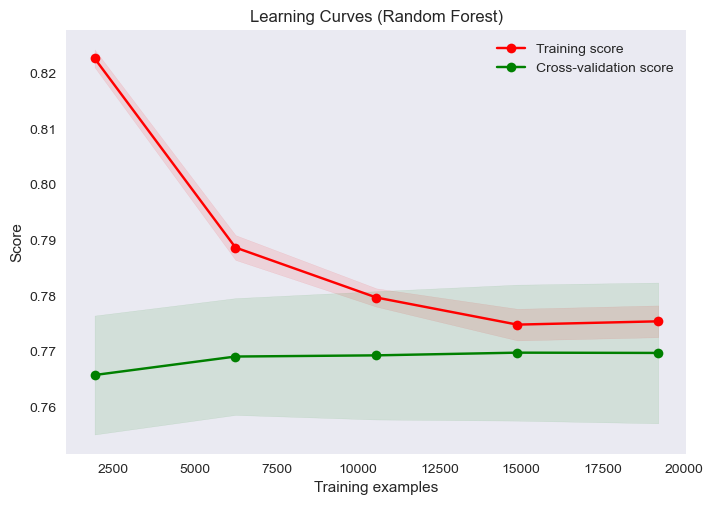

In [78]:
train_sizes, train_scores, test_scores = learning_curve(estimator=rf_clf_rscv,
                                                        X=X_train_transformed,
                                                        y=y_train,
                                                        cv=5,
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        scoring='roc_auc',)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.title('Learning Curves (Random Forest)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.legend(loc='best');

The training score is high at the beginning and decreases and the cross-validation score is slightly low at the beginning and increases; the training score and the cross-validation score are both not very encouraging at the end.

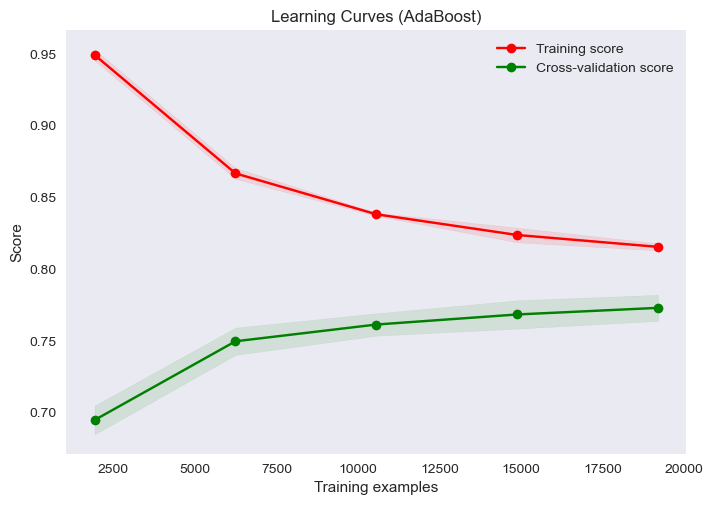

In [80]:
train_sizes, train_scores, test_scores = learning_curve(estimator=ab_clf_rscv,
                                                        X=X_train_transformed,
                                                        y=y_train,
                                                        cv=5,
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        scoring='roc_auc',)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.title('Learning Curves (AdaBoost)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.legend(loc='best');

The training score is high at the beginning and decreases and the cross-validation score is low at the beginning and increases; the training score and the cross-validation score are both not very encouraging at the end.

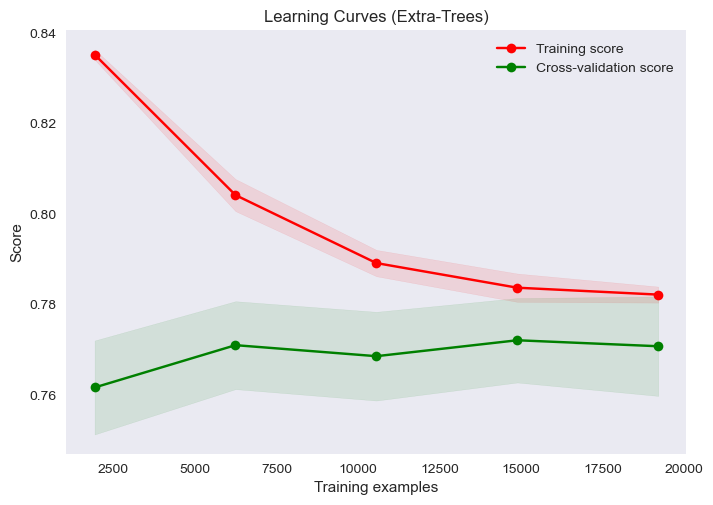

In [82]:
train_sizes, train_scores, test_scores = learning_curve(estimator=et_clf_rscv,
                                                        X=X_train_transformed,
                                                        y=y_train,
                                                        cv=5,
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        scoring='roc_auc',)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.title('Learning Curves (Extra-Trees)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.legend(loc='best');

The training score is high at the beginning and decreases and the cross-validation score is low at the beginning and increases; the training score and the cross-validation score are both not very encouraging at the end.

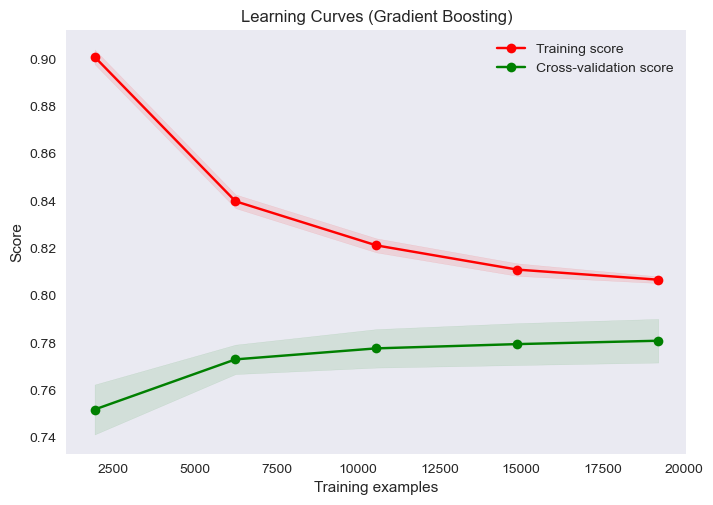

In [84]:
train_sizes, train_scores, test_scores = learning_curve(estimator=gb_clf_rscv,
                                                        X=X_train_transformed,
                                                        y=y_train,
                                                        cv=5,
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        scoring='roc_auc',)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.title('Learning Curves (Gradient Boosting)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.legend(loc='best');

The training score is high at the beginning and decreases and the cross-validation score is low at the beginning and increases; the training score and the cross-validation score are both not very encouraging at the end.

Hyperparameters directly control the behavior of the training algorithm and have a significant impact on the performance of the model being trained.

In our case, the models with hyperparameter tuning using randomized search perform slightly better than the models with default hyperparameters. The Decision Tree classifier with manual hyperparameter tuning performs much worse than the same classifiers but with default hyperparameters or with hyperparameter tuning using randomized search. For your reference (the *roc_auc_score* always runs from 0 to 1; 0.5 is the baseline for random guessing):

In [88]:
data = {
    'Decision Tree': [dt_clf_0_scores.mean(), dt_clf_rscv_scores.mean()],
    'Random Forest': [rf_clf_0_scores.mean(), rf_clf_rscv_scores.mean()],
    'AdaBoost': [ab_clf_0_scores.mean(), ab_clf_rscv_scores.mean()],
    'Extra-Trees': [et_clf_0_scores.mean(), et_clf_rscv_scores.mean()],
    'Gradient Boosting': [gb_clf_0_scores.mean(), gb_clf_rscv_scores.mean()]
}
pd.DataFrame.from_dict(data,
                       orient='index',
                       columns=['w/o hyperparameter tuning (default hyperparameters values)',
                                'w/ hyperparameter tuning'])

,w/o hyperparameter tuning (default hyperparameters values),w/ hyperparameter tuning
Decision Tree,0.611606,0.742599
Random Forest,0.763042,0.769796
AdaBoost,0.771361,0.773004
Extra-Trees,0.745949,0.770805
Gradient Boosting,0.780175,0.780887


The two things that can make things wrong are "bad algorithm" and "bad data". Since we use the same data to train our models, let's explore the chosen algorithms closer.

AUC-ROC is a valuable metric used to evaluate the performance of classification models. Our models' slightly different AUC-ROC values (see table above) can be explained by their strengths and weaknesses.

For example, even though Decision Tree is one of the most useful machine learning algorithms, it is a weak learner on its own. Trees ensemble methods are better than simple decision trees.

It is often debated whether to use Extra Trees or Random Forest as ensemble methods since they are so similar. Among the main differences, Random Forest uses bootstrap replicas, that is, it subsamples the input data with replacement, while Extra Trees examines the entire sample. In Extra Trees, there is an option to bootstrap replicas, but by default, the entire input sample is used. This may increase variance since bootstrapping makes it more diversified.

Another difference is the cut points used in order to split nodes. Extra Trees chooses the split randomly, while Random Forest chooses it based on the optimum split. However, the two algorithms will select the most appropriate split point from the subset of features once the split points have been selected. Thus, Extra Trees adds randomization while still having optimization.

The reduction of both bias and variance is motivated by these differences. By using the whole original sample instead of a bootstrap replica, bias will be reduced. Choosing randomly the split point of each node will, however, reduce variance.

Computationally speaking, the Extra Trees algorithm is faster. Since the whole procedure is the same, but it randomly chooses the split point and does not calculate the optimal one, this algorithm saves time.

In our case, the obtained results are nearly the same for both algorithms. Taking note of the execution times difference, Extra Trees is much faster. As a result, it seems useful to use Extra Trees since the same result can be obtained much faster.

As with any other ensemble algorithm, the idea behind Boosting is to combine a few weak learners into one that is stronger. In boosting models, predictors are tried sequentially, and the subsequent model attempts to correct the mistakes of its predecessor. 

There are some differences between the AdaBoost algorithm and modern Gradient Boosting. In the AdaBoost algorithm, the “shortcomings” of existing weak learners are identified by high-weight data points, however, in Gradient Boosting, the shortcomings are identified by gradients.

AUC-ROC values for AdaBoost and Gradient Boosting are similar in our case, however, Gradient Boosting has a slightly higher value. Also, they are both relatively slow.

Let's measure the performance of the best model on the test set:

In [101]:
y_probas_et_clf_test = cross_val_predict(et_clf_rscv, X_test_transformed, y_test, cv=5, method='predict_proba')
y_scores_et_clf_test = y_probas_et_clf_test[:, 1]
fpr_et_clf_test, tpr_et_clf_test, thresholds_et_clf_test = roc_curve(y_test, y_scores_et_clf_test)

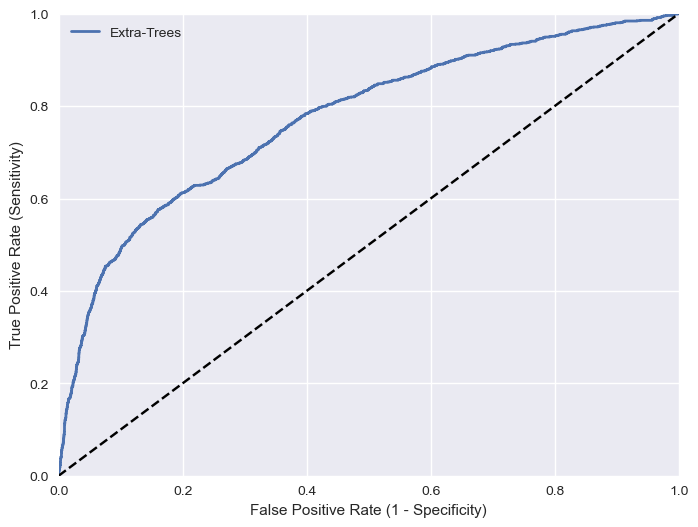

In [102]:
plt.figure(figsize=(8,6))
plt.plot(fpr_et_clf_test, tpr_et_clf_test, linewidth=2, label='Extra-Trees')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])                                   
plt.xlabel('False Positive Rate (1 - Specificity)') 
plt.ylabel('True Positive Rate (Sensitivity)')   
plt.legend()
plt.grid(True)

In [103]:
roc_auc_score(y_test, y_scores_et_clf_test)

0.772332392259337